# Divvy Data Analysis
**View on:** [nbviewer](https://nbviewer.jupyter.org/github/chrisluedtke/divvy-data-analysis/blob/master/notebook.ipynb), [Google Colab](https://colab.research.google.com/github/chrisluedtke/divvy-data-analysis/blob/master/notebook.ipynb)

![animation](https://github.com/chrisluedtke/divvy-data-analysis/blob/master/img/divvy_day.gif?raw=true)
<center><a href="https://www.youtube.com/embed/SVueGQPpz14?modestbranding=1&loop=1&rel=0">View on YouTube</a></center>

**Contents**
* [Data-Sourcing](#Data-Sourcing)
* [Exploration](#Exploration)
* [Merge-Station-Coordinates](#Merge-Station-Coordinates)
* [Farthest-Ridden-Bike](#Farthest-Ridden-Bike)
* [Calculate-Distances](#Calculate-Distances)
* [Exploration-with-Distance](#Exploration-with-Distance)
* [Check-Daylight-Savings](#Check-Daylight-Savings)
* [Animated-Plot](#Animated-Plot)
* [Perception-of-Circle-Size](#Perception-of-Circle-Size)
* [Dualmap](http://localhost:8889/notebooks/GitHub/divvy-data-analysis/notebook.ipynb#Dualmap)

In [1]:
import os

%matplotlib inline
import folium
import folium.plugins
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import divvydata
from nb_utils.colors import linear_gradient, polylinear_gradient
from nb_utils.data_processing import my_melt, add_empty_rows
from nb_utils.geospatial import haversine
from nb_utils.mapping import (create_map, gen_maps_by_group, 
                              render_html_map_to_png)

pd.options.display.max_columns = None
plt.style.use('seaborn')
sns.set_context('talk', rc={'figure.figsize':(10, 7)})

## Data Sourcing
Data from: https://www.divvybikes.com/system-data

In [2]:
help(divvydata.get_historical_data)

Help on function get_historical_data in module divvydata.historical_data:

get_historical_data(years:List[str], write_to:str=None, rides=True, stations=True)
    Gathers and cleans historical Divvy data
    
    write_to: optional local folder path to extract zip files to
    returns: (pandas.DataFrame of rides, pandas.DataFrame of stations)



In [3]:
help(divvydata.StationsFeed)

Help on class StationsFeed in module divvydata.stations_feed:

class StationsFeed(builtins.object)
 |  Client that pulls data from Divvy JSON feed:
 |  
 |  https://feeds.divvybikes.com/stations/stations.json
 |  
 |  Methods defined here:
 |  
 |  __init__(self)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  monitor_data(self, interval_sec=5, runtime_sec=1000)
 |      Listens to JSON feed and tracks events.
 |      
 |      interval_sec: default 5 seconds.
 |      runtime_sec: default 1000 seconds. Set to None to run indefinitely.
 |      
 |      returns: pandas.DataFrame
 |  
 |  update_data(self)
 |      Overwrites `data` attribute with most recent station data.
 |  
 |  ----------------------------------------------------------------------
 |  Static methods defined here:
 |  
 |  get_current_data()
 |      Pulls current data. Does not assign to an attribute.
 |  
 |  ----------------------------------------------------------------------
 |  Data d

In [16]:
# rides, stations = divvydata.get_historical_data(
#     years=[str(yr) for yr in range(2013,2019)],
#     rides=True, 
#     stations=True
# )

In [15]:
# rides.to_pickle('data/rides.pkl')
# stations.to_pickle('data/stations.pkl')

In [8]:
rides = pd.read_pickle('data/rides.pkl')
# drop unused cols to save space
rides = rides.drop(columns=['from_station_name', 'to_station_name'])
print(rides.shape)
rides.head()

(17425340, 10)


,bikeid,birthyear,end_time,from_station_id,gender,start_time,to_station_id,trip_id,tripduration,usertype
356742,914,1982.0,2013-06-27 09:46:00,91,Male,2013-06-27 01:06:00,48,3940,31177.0,Subscriber
356744,711,1982.0,2013-06-27 11:11:00,88,Male,2013-06-27 11:09:00,88,4113,140.0,Subscriber
356745,711,1982.0,2013-06-27 11:13:00,88,Male,2013-06-27 11:12:00,88,4119,87.0,Subscriber
356746,145,1978.0,2013-06-27 14:38:00,17,Male,2013-06-27 11:24:00,61,4134,11674.0,Subscriber
356747,711,1982.0,2013-06-27 16:01:00,88,Male,2013-06-27 11:39:00,34,4162,15758.0,Subscriber


In [9]:
stations = pd.read_pickle('data/stations.pkl')
stations = stations.rename(columns={'latitude':'lat', 'longitude':'lon'})
print(stations.shape)
stations.head()

(4846, 7)


,as_of_date,dpcapacity,id,lat,lon,name,online_date
900,2015-12-31,35,2,41.872293,-87.624091,Michigan Ave & Balbo Ave,NaT
1421,2016-06-30,35,2,41.872667,-87.623971,Buckingham Fountain,2015-05-08 00:00:00
2847,2016-09-30,35,2,41.872638,-87.623979,Michigan Ave & Balbo Ave,2015-05-08 00:00:00
2266,2016-12-31,35,2,41.872638,-87.623979,Michigan Ave & Balbo Ave,2015-05-08 00:00:00
3123,2017-06-30,27,2,41.881060,-87.619486,Buckingham Fountain,2013-06-10 10:43:46


## Exploration

In [7]:
rides.isna().sum()

bikeid                   0
birthyear          4328042
end_time                 0
from_station_id          0
gender             4335754
start_time               0
to_station_id            0
trip_id                  0
tripduration             0
usertype                 0
dtype: int64

count    6386.000000
mean     2728.678359
std       871.209718
min         2.000000
25%      2059.250000
50%      2779.500000
75%      3427.000000
max      5164.000000


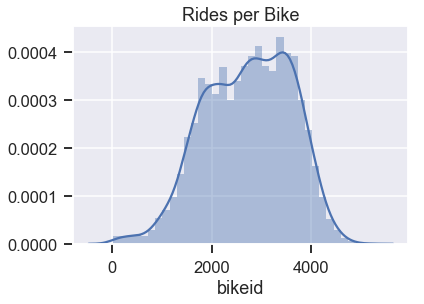

In [11]:
# How many times has each bike been ridden?
bike_use = rides['bikeid'].value_counts()
print(bike_use.describe().to_string())
sns.distplot(bike_use)
plt.title('Rides per Bike');

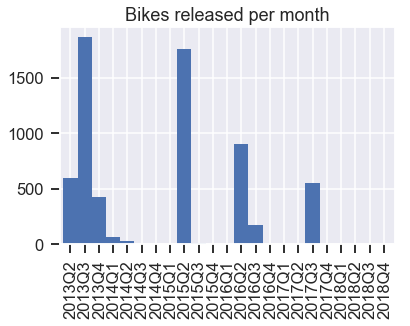

In [12]:
# Count of bikes released per month
frst_use = (rides.groupby('bikeid')['start_time'].min()
                 .dt.to_period("Q")
                 .rename('first_use_quarter'))

quarterly_counts = frst_use.value_counts()

all_dates = pd.date_range(start=rides.start_time.min().date(), 
                          end=rides.start_time.max().date(), 
                          freq='Q').to_period("Q")

all_dates = pd.Series(index=all_dates,
                      data=0)

all_dates.update(quarterly_counts)

all_dates.plot(kind='bar', width=1, 
               title='Bikes released per month');

In [13]:
# # color bike usage by quarter first ridden
# bike_use_q = rides[['bikeid']].merge(frst_use, left_on='bikeid',
#                                      right_index=True, how='left')
# bike_use_q = bike_use_q.sort_values('first_use_quarter')

# top8_qs = frst_use.value_counts().index[:8]
# bike_use_q = bike_use_q.loc[bike_use_q['first_use_quarter'].isin(top8_qs)]

# bike_use_grpd = bike_use_q.groupby('first_use_quarter')

# for group_name, group_df in bike_use_grpd:
#     group_df = group_df['bikeid'].value_counts()
#     sns.distplot(group_df)
#     plt.xlim([0, 5000])
#     plt.title(f'{group_name} bikes')
#     plt.show();

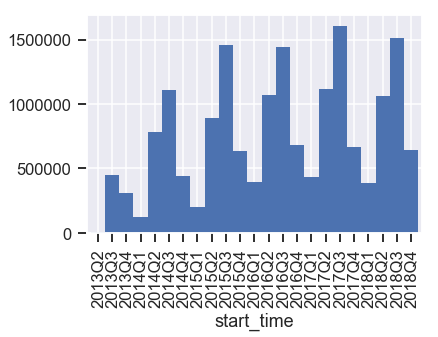

In [14]:
# Count of quarterly rides
(rides['start_time'].groupby([rides.start_time.dt.to_period("Q")])
                    .count()
                    .plot.bar(width=1));

Trip Duration (Minutes)
count    1.742534e+07
mean     1.821090e+01
std      2.739044e+02
min      1.000000e+00
25%      6.850000e+00
50%      1.176667e+01
75%      1.995000e+01
max      2.389400e+05


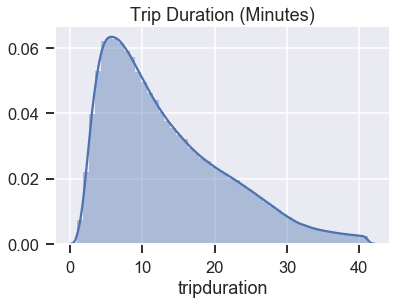

In [15]:
print('Trip Duration (Minutes)')
print(rides.tripduration.divide(60).describe().to_string())
sns.distplot(rides.loc[rides.tripduration < 
                       rides.tripduration.quantile(.95),
                       'tripduration'].divide(60))
plt.title('Trip Duration (Minutes)');

In [19]:
rides.tripduration.sum() / 60 / 60 / 24 / 365 #years

603.7503168125318

In [20]:
sum_duration_bike = (rides.groupby('bikeid')['tripduration'].sum()
                          .divide(60).divide(60))
print('Bike Use (Hours)')
print(sum_duration_bike.describe().to_string())

Bike Use (Hours)
count    6386.000000
mean      828.194923
std       342.489106
min         0.369722
25%       611.624236
50%       822.267778
75%      1013.357014
max      4981.602500


## Merge Station Coordinates

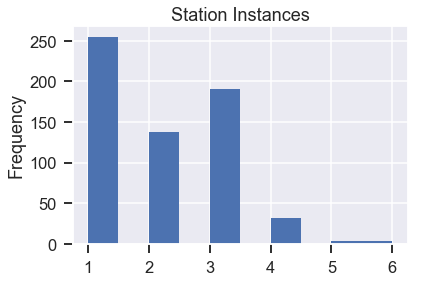

In [4]:
# Stations have moved
(stations.drop_duplicates(['id', 'lat', 'lon'])['id']
         .value_counts()
         .plot.hist(title='Station Instances'));

Unfortunately, Divvy kept the same station ID while physically moving those stations around. This adds a lot of complexity to route analysis.

One solution would be to round lat/lon coordinates to some [degree of precision](https://en.wikipedia.org/wiki/Decimal_degrees#Precision), and then remove duplicates on rounded position. While that may seem to reduce the problem, there would be no way to determine whether a station initially at position A, moved to position B, and then back to position A.

Another approach is to calculate the rolling difference of lat/lon coordinates and filter out differences below a desired precision. Let's do that.

In [5]:
fix_stns = stations.copy()

fix_stns = fix_stns.sort_values(['id', 'as_of_date'])

fix_stns['dist_m'] = np.concatenate(
    fix_stns.groupby('id')
            .apply(lambda x: haversine(
                x['lat'].values, x['lon'].values,
                x['lat'].shift().values, x['lon'].shift().values)).values
)

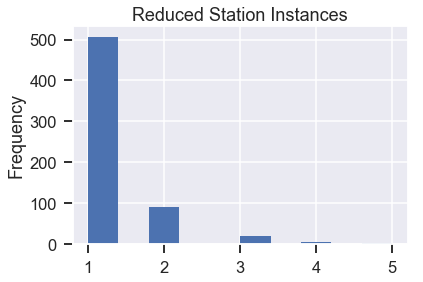

In [6]:
# NaNs are first instance, so keep those
mask = fix_stns.dist_m.isna() | (fix_stns.dist_m > 30)
fix_stns.loc[mask, 'id'].value_counts().plot(kind='hist', title='Reduced Station Instances');

We can assess the problem by plotting stations that have moved:

In [7]:
df = fix_stns.loc[fix_stns.id.duplicated(keep=False)]

m = folium.Map(location=[df.lat.mean(), 
                         df.lon.mean()],
               tiles='CartoDB dark_matter',
               zoom_start=12)

for g_k, g_df in df.groupby('id'):
    total_dist = g_df.dist_m.sum()
    if total_dist < 10:
        continue

    text = (f"Station {g_df.id.values[0]}<br>"
            f"{int(total_dist)} m")
    folium.PolyLine(
        locations=list(zip(g_df.lat, g_df.lon)), 
        tooltip=text, color="#E37222", weight=3
    ).add_to(m)
    
folium.plugins.Fullscreen(
    position='topright',
    force_separate_button=True
).add_to(m)

m.save('maps/stations_moved.html')
m

In [10]:
rides['end_date'] = rides['end_time'].dt.date

day_aggs = (rides.groupby(['to_station_id', 'end_date'])
                 .agg({'from_station_id':'median',
                       'tripduration':'mean',
                       'end_time':'count'})
                 .rename(columns={'from_station_id':'trip_origin_median',
                                  'tripduration':'trip_duration_mean',
                                  'end_time':'trip_counts'}))

as_of_date       dist_m        lat        lon
2015-12-31          NaN  41.853661 -87.635135
2016-06-30  1880.031485  41.870257 -87.639474
2016-09-30     0.000000  41.870257 -87.639474
2016-12-31     0.000000  41.870257 -87.639474
2017-06-30     0.000000  41.870257 -87.639474
2017-12-31     0.000000  41.870257 -87.639474
2019-03-05     0.000000  41.870257 -87.639474


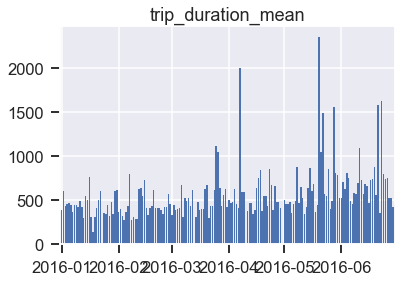

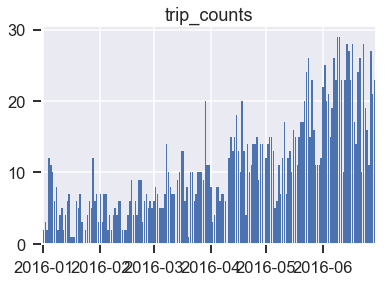

In [11]:
stn_id = 414
min_date, max_date = '2015-12-31', '2016-06-30'

grouped = fix_stns.groupby('id')
cols = ['as_of_date', 'dist_m', 'lat', 'lon']
print(grouped.get_group(stn_id)[cols].to_string(index=False))

stn_aggs = day_aggs.loc[stn_id]

dates = pd.DataFrame(data={k:0 for k in stn_aggs}, 
                     index=pd.date_range(min_date, max_date))

dates.update(stn_aggs)

for col in ['trip_duration_mean', 'trip_counts']:
    plt.bar(x=dates.index, height=dates[col])
    plt.xlim(min_date, max_date)
    plt.title(col)
    plt.show();

#### TODO
* subtract daily average of all active stations
* pick a few nearby stations -- should observe that durations change after a move
* monitor the set of station origins, should change 

From here I would create a lookup table for stations that have moved. The rows would span each day the station was active, and I would merge with my `rides` table on a `ride_id_date` key.

But for now, I'll average each duplicated station's lat/lon positions to make things easy.

In [8]:
stations = (fix_stns.groupby('id')['lat', 'lon'].mean())

In [9]:
# Merge Station Coordinates
rides = (rides.merge(stations.rename(columns={'lat':'from_lat',
                                              'lon':'from_lon'}),
                     left_on='from_station_id', right_index=True,
                     how='left')
              .merge(stations.rename(columns={'lat':'to_lat',
                                              'lon':'to_lon'}),
                     left_on='to_station_id', right_index=True,
                     how='left'))

## Calculate Distances

In [11]:
rides['dist'] = haversine(rides.from_lat, rides.from_lon, 
                          rides.to_lat,   rides.to_lon)

In [12]:
rides['taxi_dist'] = (haversine(rides.from_lat, rides.from_lon, 
                                rides.from_lat, rides.to_lon) + 
                      haversine(rides.to_lat, rides.to_lon, 
                                rides.from_lat, rides.to_lon))

In [32]:
# rides.to_pickle('data/rides_with_dist.pkl')

## Exploration with Distance

In [12]:
rides = pd.read_pickle('data/rides_with_dist.pkl')

In [13]:
rides[['dist', 'taxi_dist']].divide(1000).describe()

,dist,taxi_dist
count,1.742475e+07,1.742475e+07
mean,2.005762e+00,2.499794e+00
std,1.587529e+00,2.005664e+00
min,0.000000e+00,0.000000e+00
25%,9.254459e-01,1.145991e+00
50%,1.548781e+00,1.944045e+00
75%,2.646230e+00,3.304592e+00
max,3.679380e+01,4.167998e+01


In [14]:
sum_dist = rides.dist.sum()
m_to_moon = 384401000

print(round(sum_dist / m_to_moon / 2, 1), 'trips to the moon and back')

45.5 trips to the moon and back


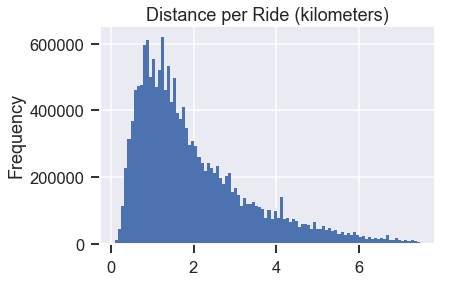

In [15]:
(rides.dist.loc[(1 < rides.dist) &
                (rides.dist < rides.dist.quantile(.99))]
     .divide(1000)
     .plot.hist(bins=100, title='Distance per Ride (kilometers)'));

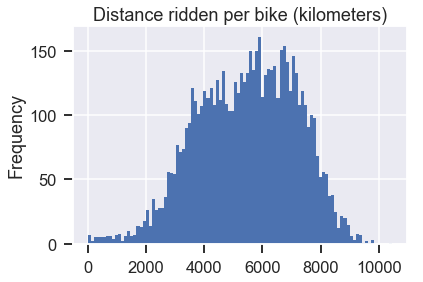

In [16]:
# sum distance ridden, km
dist_sum = rides.groupby('bikeid')['dist'].sum().divide(1000)
dist_sum.plot.hist(bins=100, title='Distance ridden per bike (kilometers)');

In [17]:
print(dist_sum.sort_values(ascending=False).head().to_string())

bikeid
410     10451.034962
1315     9785.608171
1385     9743.838634
73       9726.479546
877      9642.728393


## Farthest Ridden Bike

In [3]:
rides = pd.read_pickle('data/rides_with_dist.pkl')

In [18]:
# Path of the farthest ridden bike
df = (rides.loc[(rides.bikeid==410)]
           .sort_values('start_time'))

df['start_q'] = df.start_time.dt.to_period("Q").astype(str)

In [21]:
date_range = (pd.date_range(df['start_time'].min().date(),
                            df['start_time'].max().date())
                .to_period("Q").astype(str).unique())

colors = [
    '#fe0000', #red
    '#fdfe02', #yellow      
    '#011efe', #blue
] 

gradient = polylinear_gradient(colors, len(date_range))

date_colors = pd.Series(index=date_range, data=gradient, name='date_color')

df = df.merge(date_colors, left_on='start_q', right_index=True, how='left')

dropped 1 colors from end of the gradient


In [27]:
m = folium.Map(location=[df.from_lat.mean(), 
                         df.from_lon.mean()],
               tiles='CartoDB dark_matter',
               zoom_start=13)

for q_group, q_df in df.groupby('start_q'):
    points = []
    from_locs = list(zip(q_df.from_lat, q_df.from_lon))
    to_locs = list(zip(q_df.to_lat, q_df.to_lon))
    for from_i, to_i, in zip(from_locs, to_locs):
        points.append(from_i)
        points.append(to_i)
        
    folium.PolyLine(
        points,
        weight=1,
        color=q_df.date_color.values[0],
        tooltip=q_group.replace('Q', ' Q')
    ).add_to(m)

folium.plugins.Fullscreen(
    position='topright',
    force_separate_button=True
).add_to(m)

m.save('maps/longest_ridden_rainbow.html')

m

## Check Daylight Savings

The time component of my analysis is very important. If DST were a problem, a large number of rows could be +/- 1 hour off. 

Sanity check:

In [ ]:
rides = pd.read_pickle('data/rides_with_dist.pkl')

In [50]:
dst_start = { # clock 1:59AM to 3:00AM
    '2013':'03-10',
    '2014':'03-09',
    '2015':'03-08',
    '2016':'03-13',
    '2017':'03-12',
    '2018':'03-11',
}

for yy, mm_dd in dst_start.items():
    uh_oh = rides.loc[(f'{yy}-{mm_dd} 01:59:59' < rides['start_time']) &
                      (rides['start_time'] < f'{yy}-{mm_dd} 03:00:00')]
    if not uh_oh.empty:
        print(uh_oh)

In [52]:
# DST End, clock 1:59AM to 1:00AM
rides.loc[(rides.end_time < rides.start_time), 
          ['start_time', 'end_time', 'tripduration']]

,start_time,end_time,tripduration
13441772,2017-11-05 01:24:00,2017-11-05 01:04:00,2385.0
13441765,2017-11-05 01:29:00,2017-11-05 01:05:00,2158.0
13441752,2017-11-05 01:47:00,2017-11-05 01:04:00,1028.0
13441751,2017-11-05 01:51:00,2017-11-05 01:07:00,932.0
13441750,2017-11-05 01:54:00,2017-11-05 01:06:00,715.0
13441749,2017-11-05 01:54:00,2017-11-05 01:06:00,724.0
13441748,2017-11-05 01:54:00,2017-11-05 01:06:00,716.0
13441747,2017-11-05 01:56:00,2017-11-05 01:04:00,479.0
13441745,2017-11-05 01:58:00,2017-11-05 01:27:00,1699.0
13441746,2017-11-05 01:58:00,2017-11-05 01:13:00,887.0


## Animated Plot

Seeking animated plot where:
* circles positioned at stations
* **size** represents station usage
* **color** represents type of use (gaining bikes or losing bikes).

In [ ]:
rides = pd.read_pickle('data/rides_with_dist.pkl')

In [39]:
# subsample to get a working flow before applying to large dataset
# rides = rides.sample(10000)

In [40]:
# reshape DataFrame from 'ride' orientation to 'station interaction' orientation
rides[['from_station_id', 'start_time', 
       'to_station_id', 'end_time']].head()

,from_station_id,start_time,to_station_id,end_time
356742,91,2013-06-27 01:06:00,48,2013-06-27 09:46:00
356744,88,2013-06-27 11:09:00,88,2013-06-27 11:11:00
356745,88,2013-06-27 11:12:00,88,2013-06-27 11:13:00
356746,17,2013-06-27 11:24:00,61,2013-06-27 14:38:00
356747,88,2013-06-27 11:39:00,34,2013-06-27 16:01:00


In [41]:
stn_agg = my_melt(rides)

In [42]:
stn_agg.head()

,station_id,time,lat,lon,type
356742,91,2013-06-27 01:06:00,41.88338,-87.641170,departure
356744,88,2013-06-27 11:09:00,41.88402,-87.656271,departure
356745,88,2013-06-27 11:12:00,41.88402,-87.656271,departure
356746,17,2013-06-27 11:24:00,41.90322,-87.673333,departure
356747,88,2013-06-27 11:39:00,41.88402,-87.656271,departure


In [43]:
# actually 'half hour'
stn_agg['hour'] = (stn_agg.time.dt.hour + 
                   stn_agg.time.dt.minute // 30 * 0.5)
# stn_agg['dow'] = stn_agg.time.dt.dayofweek
stn_agg['month'] = stn_agg.time.dt.to_period('M')

# Here I assume if the station was used any time in a month,
# then it was active/available for that entire month
stn_days = (stn_agg.groupby('station_id')['month']
                   .nunique()
                   .multiply(30)
                   .rename('days_active'))

# pivot to get arrival and departure count columns
id_cols = ['station_id', 'lat', 'lon', 'hour']
stn_agg = (stn_agg.pivot_table(index=id_cols, columns='type', 
                               aggfunc='size', fill_value=0)
                  .reset_index()
                  .merge(stn_days, left_on='station_id', 
                         right_index=True))
stn_agg['total_use'] = stn_agg.arrival + stn_agg.departure
stn_agg['avg_use'] = stn_agg.total_use.divide(stn_agg.days_active, fill_value=0)
stn_agg['pt_departures'] = stn_agg.departure.divide(stn_agg.total_use, fill_value=0.5)

# stn_agg.to_pickle('data/station_aggregates.pkl')

In [3]:
stn_agg = pd.read_pickle('data/station_aggregates.pkl')

In [5]:
stn_agg.head()

,station_id,lat,lon,hour,arrival,departure,days_active,total_use,avg_use,pt_departures
0,2,41.876582,-87.621302,0.0,234,209,1320,443,0.335606,0.471783
1,2,41.876582,-87.621302,0.5,227,184,1320,411,0.311364,0.447689
2,2,41.876582,-87.621302,1.0,153,96,1320,249,0.188636,0.385542
3,2,41.876582,-87.621302,1.5,123,96,1320,219,0.165909,0.438356
4,2,41.876582,-87.621302,2.0,107,71,1320,178,0.134848,0.398876


In [6]:
## sanity checks
# (set(rides.to_station_id) | set(rides.from_station_id)) - set(stn_agg.station_id)
# (set(rides.to_station_id) | set(rides.from_station_id)) - set(stations.index)

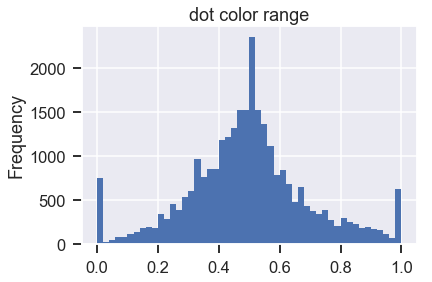

In [7]:
stn_agg.pt_departures.plot.hist(bins=50, title='dot color range');

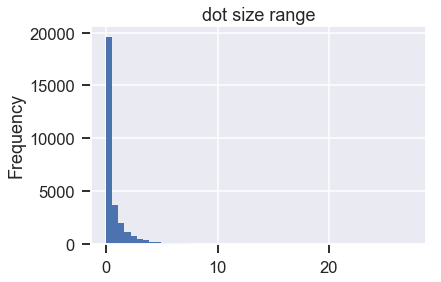

In [8]:
stn_agg.avg_use.plot.hist(bins=50, title='dot size range');

### Perception of Circle Size

If we directly map the radius of each station dot to the average use of the station, a dot of radius 2 will appear non-linearly larger than a dot of radius 1. However, if we set the **area** of the dot to the average use, I would argue that the average user would not perceive the the second dot as twice as large as the first. I could not find any empirical discussion on this.

https://eagereyes.org/blog/2008/linear-vs-quadratic-change

In my tests, a circle radius 60 is about the largest I would like a cirlce to appear, otherwise it obscures other information.

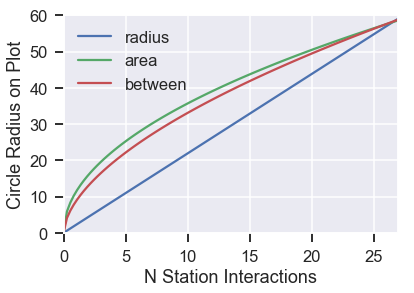

In [9]:
def radius(x):
    '''radius when radius defined by station interactions'''
    return x * 2.19

def area(x):
    '''radius when area defined by station interactions'''
    return ((x / np.pi) ** (1/2)) * 20

def between(x):
    return x ** (58/100) * 8.7

x_vals = np.linspace(0, 27, 100)
plots = pd.DataFrame({'x_vals':x_vals,
                      'radius': [radius(x) for x in x_vals],
                      'area': [area(x) for x in x_vals],
                      'between': [between(x) for x in x_vals]})
plots.plot.line(x='x_vals', xlim=(0,27), ylim=(0,60))
plt.xlabel('N Station Interactions')
plt.ylabel('Circle Radius on Plot');

In [10]:
stn_agg.loc[stn_agg.station_id==664].head()

,station_id,lat,lon,hour,arrival,departure,days_active,total_use,avg_use,pt_departures
28580,664,41.939354,-87.683282,0.0,0,1,30,1,0.033333,1.0
28581,664,41.939354,-87.683282,6.0,0,2,30,2,0.066667,1.0
28582,664,41.939354,-87.683282,8.0,1,0,30,1,0.033333,0.0
28583,664,41.939354,-87.683282,9.0,0,1,30,1,0.033333,1.0
28584,664,41.939354,-87.683282,11.0,3,2,30,5,0.166667,0.4


In [11]:
def expand_and_interpolate(df):
    # expand by every half hour and fill with zeros
    steps = 24 * 2
    hours = pd.Series(np.linspace(0, 24, steps, endpoint=False),
                      index=[1]*steps, name='hour')
    df = add_empty_rows(df=stn_agg, fill_series=hours, 
                        constants=['station_id', 'lat','lon', 'days_active'])
    df['pt_departures'] = df['pt_departures'].fillna(0.50)
    df = df.fillna(0)

    # expand by every 2 minutes and fill with interpolation
    steps = 24 * 2 * 15
    hours = pd.Series(np.linspace(0, 24, steps, endpoint=False).round(3),
                      index=[1]*steps, name='hour')
    df = add_empty_rows(df=df, fill_series=hours, 
                        constants=['station_id', 'lat','lon', 'days_active'])

    # add hour 24 that matches hour 0
    df = (df.append(df.loc[df['hour']==df['hour'].min()]
                      .assign(hour=24))
            .sort_values(['station_id', 'hour']))

    df[['avg_use', 'pt_departures']] = df[['avg_use', 'pt_departures']].interpolate()
    
    return df


def get_percent_depart_gradient():
    # Generate color gradient for each percentage pt_departures
    strt_color = "#18f0da" #blue, gathering bikes
    mid_color = "#e6e6e6"  #gray
    end_color = "#f06e18"  #orange, "radiating" bikes
    start_pos = 25
    mid_width = 5

    steps = int((100 - start_pos * 2 - mid_width) / 2) + 1

    color_list = ([strt_color] * start_pos +
                  linear_gradient(strt_color, mid_color, steps) + 
                  [mid_color] * mid_width +
                  linear_gradient(mid_color, end_color, steps) + 
                  [end_color] * start_pos)

    gradient = pd.Series(data=color_list,
                         index=np.linspace(0, 1, 101, endpoint=True).round(2),
                         name='color')
    return gradient

In [12]:
stn_agg_interp = expand_and_interpolate(df=stn_agg)

gradient = get_percent_depart_gradient()

stn_agg_interp['pt_departures_rd'] = stn_agg_interp['pt_departures'].round(2)
stn_agg_interp = (stn_agg_interp.drop(columns='color', errors='ignore')
                                .merge(gradient, left_on='pt_departures_rd', 
                                       right_index=True, how='left'))
stn_agg_interp['radius'] = stn_agg_interp.avg_use.apply(between)

In [15]:
create_map??

In [38]:
create_map(stn_agg_interp.loc[stn_agg_interp.hour==17])

In [39]:
gen_maps_by_group(stn_agg_interp, group_label='hour', height_px=1350, 
                  width_px=int(1350*1.777), preview=True)

From here I use `gen_maps_by_group` to generate `.html` maps for each frame of the animation, then `render_maps_dir_to_pngs` to iterate over the maps to `.png`.

In [ ]:
maps_dir = os.path.join(os.getcwd(), 'maps')
output_dir = os.path.join(os.getcwd(), 'maps/pngs')

In [44]:
help(render_html_map_to_png)

Help on function render_html_map_to_png in module utils.mapping:

render_html_map_to_png(map_path, output_path, map_x_px=None, map_y_px=None, driver=None, sleep_s=3.0, quit_after=True, preview=False)



## Dualmap

In [40]:
def add_to_dualmap(df, m, add_to):
    for i, r in df.iterrows():
        if r.avg_use < 0.01:
            continue
        popup_txt=(f'<h5>Station {r.station_id}</h5><br>'
                   f'Avg Uses: {round(r.avg_use,1)}<br>'
                   f'Departures: {round(r.pt_departures*100)}%')
        folium.CircleMarker(
            location=(r.lat, r.lon),              
            radius=r.radius,
            color=r['color'],
            weight=0.5,
            popup=folium.Popup(popup_txt, max_width=500),
            fill=True).add_to(add_to)
            
    return m

m = folium.plugins.DualMap(
    location=(41.89, -87.63), 
    tiles="CartoDB dark_matter", 
    zoom_start=14)

m = add_to_dualmap(stn_agg_interp.loc[stn_agg_interp.hour==8],
                   m, m.m1)

m = add_to_dualmap(stn_agg_interp.loc[stn_agg_interp.hour==17],
                   m, m.m2)

m.save('maps/am_v_pm.html')

m